In [7]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import src

# Step 1: Generate community-based social network

In [9]:
distances_np = np.load('../data/southpark_distance_matrix.npy')

"""Step 1: Community-based social network construction"""
# create a community
community = src.Community()
community.add_nodes_from(range(distances_np.shape[0]))

# generate social ties
np.random.seed(0)
degree_list = np.random.negative_binomial(0.8266, 0.0669, size=distances_np.shape[0])
degree_list = degree_list*1
degree_list = degree_list.astype(int)
community.generate_social_ties(degrees=degree_list, distance_matrix=distances_np, distance_decay_alpha=-1.43, seed=1)
community.split_social_ties(types=["strong", "weak"], pmf=[0.298, 0.702], seed=2)

"""Step 2: Community-based resource-sharing network construction"""
# generate sharing preferences
sharing_preferences = pd.read_csv('../data/southpark_share_pref_PMF.csv')['transp']
# sharing_preferences = [0.2, 0.2, 0.2, 0.4]
community.generate_sharing_preference(recipient=[0, 1, 2, 3], pmf=sharing_preferences, name='transp_share_preference', seed=3)

"""Step 3: Community-based resource distribution"""
resource_distribution = pd.read_csv('../data/southpark_resource_distr_PMF.csv')['transp']
community.generate_resource_inventory(support=np.arange(0, len(resource_distribution)), pmf=resource_distribution, name='transp', seed=4)

# create sharing network
share_network = community.get_share_network('transp_share_preference', priority=[3, 2, 1])

Social tie matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Sum of social tie matrix:
14554
Average number of social ties per household:
10.554024655547499


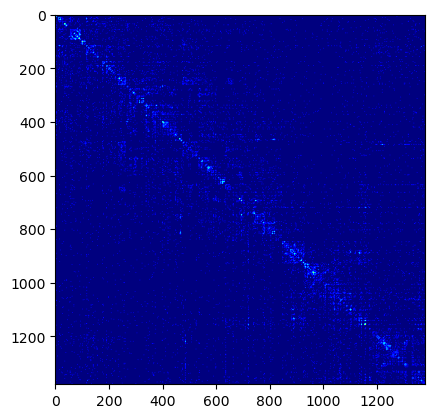

In [3]:
strong_tie_matrix = community.get_social_tie_matrix(type="strong")
weak_tie_matrix = community.get_social_tie_matrix(type="weak")
social_tie_matrix = strong_tie_matrix + weak_tie_matrix
stranger_tie_matrix = np.ones_like(social_tie_matrix) - social_tie_matrix

print("Social tie matrix:")
print(social_tie_matrix)
print("Sum of social tie matrix:")
print(np.sum(social_tie_matrix))
print("Average number of social ties per household:")
print(np.sum(social_tie_matrix)/social_tie_matrix.shape[0])
plt.imshow(social_tie_matrix, cmap='jet')
plt.show()

Strong tie matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Sum of strong tie matrix:
2234.0
Weak tie matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Sum of weak tie matrix:
5043.0


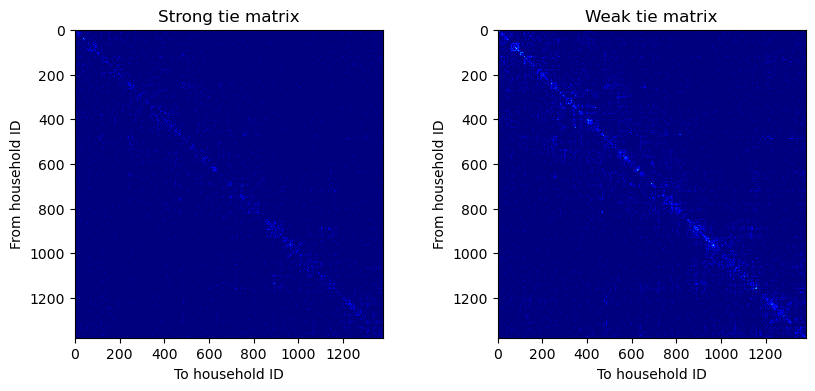

In [4]:
print("Strong tie matrix:")
print(strong_tie_matrix)
print("Sum of strong tie matrix:")
print(np.sum(strong_tie_matrix)/2)
print("Weak tie matrix:")
print(weak_tie_matrix)
print("Sum of weak tie matrix:")
print(np.sum(weak_tie_matrix)/2)

# plot the strong tie matrix and weak tie matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(strong_tie_matrix, cmap='jet')
axs[0].set_xlabel('To household ID')
axs[0].set_ylabel('From household ID')
axs[0].set_title('Strong tie matrix')
axs[1].imshow(weak_tie_matrix, cmap='jet')
axs[1].set_xlabel('To household ID')
axs[1].set_ylabel('From household ID')
axs[1].set_title('Weak tie matrix')
plt.show()

Stranger tie matrix:
[[1 1 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Sum of stranger tie matrix:
1887087


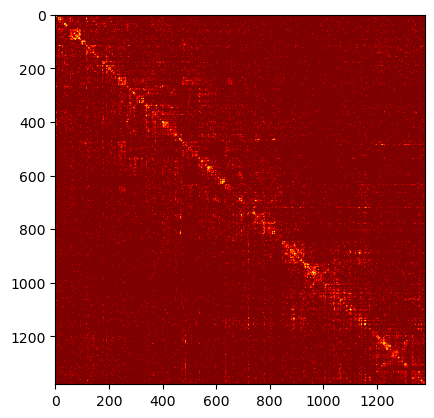

In [5]:
print("Stranger tie matrix:")
print(stranger_tie_matrix)
print("Sum of stranger tie matrix:")
print(np.sum(stranger_tie_matrix))
plt.imshow(stranger_tie_matrix, cmap='jet')
plt.show()

## Area2Area social ties

In [6]:
households_df = pd.read_csv('../data/southpark_address.csv')
households_df

FileNotFoundError: [Errno 2] No such file or directory: '../data/southpark_address.csv'

In [ ]:
household_areas = households_df['area']
num_households = np.array([
    household_areas.value_counts()['A'],
    household_areas.value_counts()['B'],
    household_areas.value_counts()['C'],
    household_areas.value_counts()['D'],
    household_areas.value_counts()['E'],
    household_areas.value_counts()['F']
])

# Define a dictionary to map area letters to indices
area_indices = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

# Initialize a 7x7 matrix with zeros
strong_tie_area_matrix = np.zeros((6, 6))
weak_tie_area_matrix = np.zeros((6, 6))

# Loop through the social tie matrix
for i in range(np.shape(social_tie_matrix)[0]):
    for j in range(np.shape(social_tie_matrix)[1]):
        if social_tie_matrix[i, j] == 1:
            # Determine the area of the household
            area_i = household_areas[i]
            area_j = household_areas[j]

            # Determine the row index based on the area
            row = area_indices[area_i]
            col = area_indices[area_j]

            # Add 1 to the strong tie matrix if the strong tie matrix has 1
            if strong_tie_matrix[i, j] == 1:
                strong_tie_area_matrix[row, col] += 1
            # Add 1 to the weak tie matrix if the weak tie matrix has 1
            elif weak_tie_matrix[i, j] == 1:
                weak_tie_area_matrix[row, col] += 1

# count the number of household in each area
households_df['area'].value_counts()

print("Area average strong tie matrix:")
display(np.round(strong_tie_area_matrix/num_households, decimals=2))
print("Area average weak tie matrix:")
display(np.round(weak_tie_area_matrix/num_households, decimals=2))
print("Area average social tie matrix:")
display(np.round((strong_tie_area_matrix + weak_tie_area_matrix)/num_households, decimals=2))
print("Total number of strong ties:")
print(np.sum(strong_tie_area_matrix))
print("Total number of weak ties:")
print(np.sum(weak_tie_area_matrix))
print("Total number of ties:")
print(np.sum(strong_tie_area_matrix + weak_tie_area_matrix))
print("Average number of ties per household:")
print(np.sum(strong_tie_area_matrix + weak_tie_area_matrix)/np.sum(num_households))

Area average strong tie matrix:


array([[1.71, 0.51, 0.32, 0.13, 0.3 , 0.15],
       [0.43, 1.57, 0.34, 0.1 , 0.11, 0.09],
       [0.72, 0.93, 1.93, 0.28, 0.44, 0.48],
       [0.08, 0.08, 0.08, 1.61, 0.34, 0.24],
       [0.46, 0.2 , 0.3 , 0.83, 1.83, 0.85],
       [0.06, 0.04, 0.08, 0.15, 0.22, 1.98]])

Area average weak tie matrix:


array([[4.02, 1.14, 0.64, 0.29, 0.59, 0.26],
       [0.94, 3.74, 0.77, 0.17, 0.32, 0.35],
       [1.44, 2.1 , 4.39, 0.55, 1.15, 1.21],
       [0.18, 0.13, 0.16, 3.76, 0.69, 0.76],
       [0.92, 0.6 , 0.8 , 1.69, 4.12, 1.82],
       [0.1 , 0.17, 0.21, 0.47, 0.46, 3.41]])

Area average social tie matrix:


array([[5.73, 1.65, 0.97, 0.42, 0.89, 0.4 ],
       [1.37, 5.31, 1.12, 0.27, 0.42, 0.44],
       [2.16, 3.03, 6.32, 0.83, 1.59, 1.68],
       [0.27, 0.21, 0.24, 5.36, 1.03, 1.  ],
       [1.38, 0.8 , 1.11, 2.52, 5.95, 2.67],
       [0.16, 0.21, 0.3 , 0.62, 0.68, 5.39]])

Total number of strong ties:
4468.0
Total number of weak ties:
10086.0
Total number of ties:
14554.0
Average number of ties per household:
10.554024655547499


In [ ]:
# A prediction of the number of ties in the social network
1380/205*1292

8697.365853658537

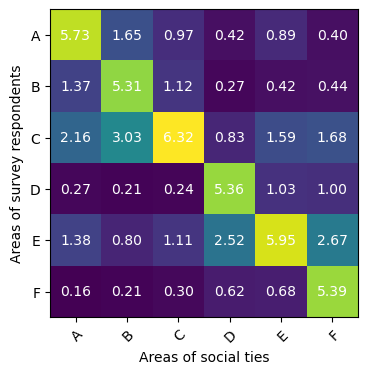

In [ ]:
# create data
data = (strong_tie_area_matrix + weak_tie_area_matrix)/num_households

# create figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# plot data as grid
im = ax.imshow(data, cmap='viridis')

# add colorbar
# cbar = ax.figure.colorbar(im, ax=ax)

# set axis labels
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))
ax.set_xticklabels(np.arange(data.shape[1])+1)
ax.set_yticklabels(np.arange(data.shape[0])+1)

# set axis tick labels to be readable
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# add title
# ax.set_title("2D Grid Plot")
ax.set_xlabel('Areas of social ties')
ax.set_ylabel('Areas of survey respondents')
# set x-ticklabels as A, B, C, D, E, F, G
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])
# set y-ticklabels as A, B, C, D, E, F, G
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F'])

# add text annotations for each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i, j]:.2f}', ha="center", va="center", color="w")

# save plot
plt.savefig('../figs/southpark_gener_social_tie.png', dpi=300, bbox_inches='tight')

## Plot the social network

In [ ]:
import geopandas as gpd
import networkx as nx
import contextily as cx

d:\Software\Anaconda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


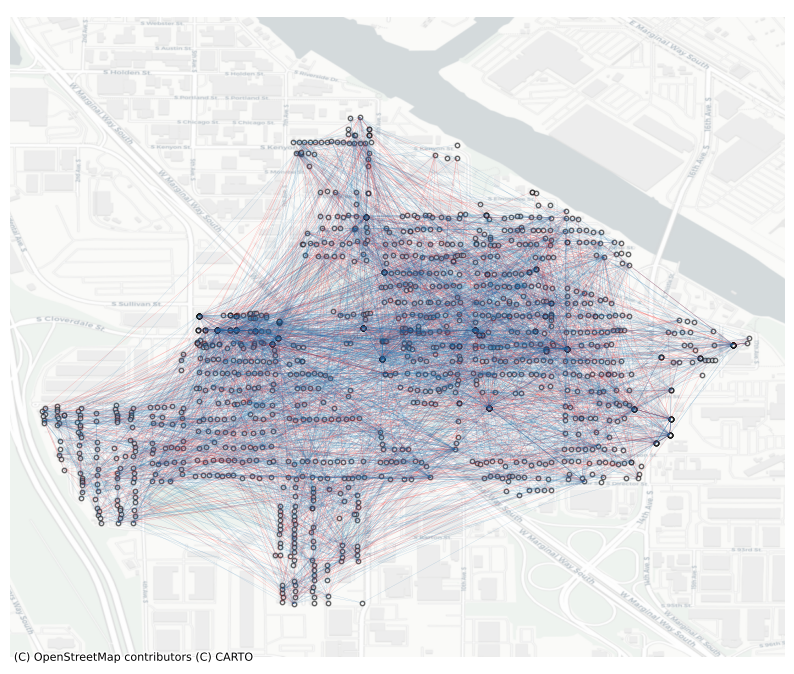

In [ ]:
node_list = households_df['ID'].tolist()
node_pos = households_df[['longitude', 'latitude']].values
strong_ties = np.argwhere(strong_tie_matrix == 1).tolist()
weak_ties = np.argwhere(weak_tie_matrix == 1).tolist()
edge_list = strong_ties + weak_ties

# Create a GeoDataFrame from the households DataFrame
geometry = gpd.points_from_xy(node_pos[:,0], node_pos[:,1])
gdf = gpd.GeoDataFrame(households_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}

# Create a NetworkX graph from the edge list
G = nx.Graph()
G.add_nodes_from(gdf['ID'])
G.add_edges_from(edge_list)

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame nodes
gdf.plot(ax=ax, markersize=10, color='white', alpha=0.6, edgecolor='black')

# Plot the NetworkX edges
nx.draw_networkx_edges(
    G,
    pos=node_pos,
    edgelist=strong_ties,
    width=0.1,
    alpha=0.3,
    edge_color="red",
    label="Strong ties"
)

nx.draw_networkx_edges(
    G,
    pos=node_pos,
    edgelist=weak_ties,
    width=0.1,
    alpha=0.3,
    edge_color="tab:blue",
    label="Weak ties"
)

# add base map
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)
# zoom out a little bit
ax.set_xlim(-122.3335, -122.311)
ax.set_ylim(47.517, 47.536)

plt.axis('off')
plt.show()

# save the figure
fig.savefig('../figs/southpark_social_tie_net.png', dpi=300, bbox_inches='tight', transparent=True)

# Step 2: Community-based P2P resource-sharing network construction

In [ ]:
# show the number of nodes and edges
print("# of nodes = ", len(share_network.nodes))
print("# of links = ", len(share_network.edges))

# number of links corresponding to strong ties
num_strong_links = 0
for e in share_network.edges:
    if share_network.edges[e]['weight'] == 3:
        num_strong_links += 1
num_weak_links = 0
for e in share_network.edges:
    if share_network.edges[e]['weight'] == 2:
        num_weak_links += 1
num_stranger_links = len(share_network.edges) - num_strong_links - num_weak_links

# print("# of strong links = ", num_strong_links, "percentage = ", num_strong_links/len(share_network.edges))
# print("# of weak links = ", num_weak_links, "percentage = ", num_weak_links/len(share_network.edges))
# print("# of stranger links = ", num_stranger_links, "percentage = ", num_stranger_links/len(share_network.edges))

# of nodes =  1379
# of links =  721521


# Step 3: Community-based resource distribution with inventory

d:\Software\Anaconda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\LI Zhengyang\AppData\Local\Temp\ipykernel_22400\2328539377.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('copper')  # Choose a colormap


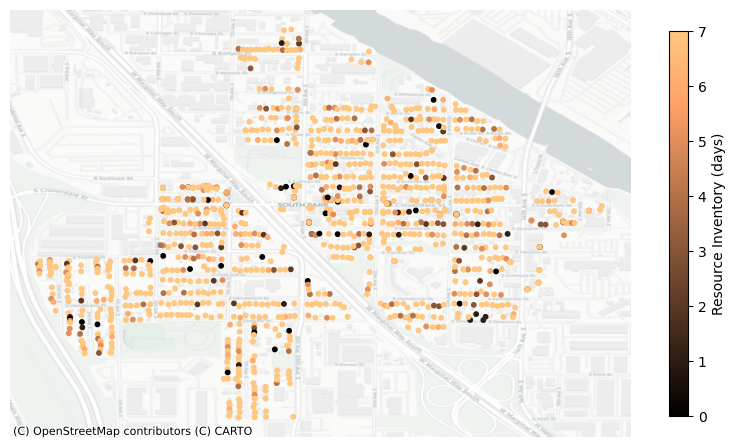

In [ ]:
node_list = households_df['ID'].tolist()
node_pos = households_df[['longitude', 'latitude']].values

geometry = gpd.points_from_xy(node_pos[:,0], node_pos[:,1])
gdf = gpd.GeoDataFrame(households_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}

fig, ax = plt.subplots(figsize=(10, 10))

# set the node color to be proportional to the resource inventory
resource_inventory = [community.nodes[n]['transp'] for n in node_list]
cmap = plt.cm.get_cmap('copper')  # Choose a colormap
node_color = resource_inventory / max(resource_inventory)
node_color_mapped = cmap(node_color)

# Plot the GeoDataFrame
gdf.plot(ax=ax, markersize=10, color=node_color_mapped, alpha=1)

# add base map
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(resource_inventory)
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label('Resource Inventory (days)')

plt.axis('off')
plt.show()

# save the figure
fig.savefig("../figs/southpark_transp_resource_inventory.png", dpi=300, bbox_inches='tight')

# Step 4: Community-based P2P resource-sharing model

In [ ]:
priority_matrix = community.get_share_priority_matrix(sharing_preference='transp_share_preference', priority=[3, 2, 1])
resource_inventory = [community.nodes[n]['transp'] for n in node_list]
model = src.ResourceSharingModel(priority_matrix, resource_inventory, isolation_days=6)
model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-31
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10700 CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2758 rows, 1901641 columns and 3803282 nonzeros
Model fingerprint: 0xdf98a397
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 1892 rows and 1795912 columns
Presolve time: 0.85s
Presolved: 866 rows, 105729 columns, 211373 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 5.672e+04
 Factor NZ  : 1.004e+05 (roughly 24 MB of memory)
 Factor Ops : 2.587e+07 (less than 1 second per iteration)
 Threads    : 6

Barrier performed

C:\Users\LI Zhengyang\AppData\Local\Temp\ipykernel_22400\2139286549.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('copper')  # Choose a colormap


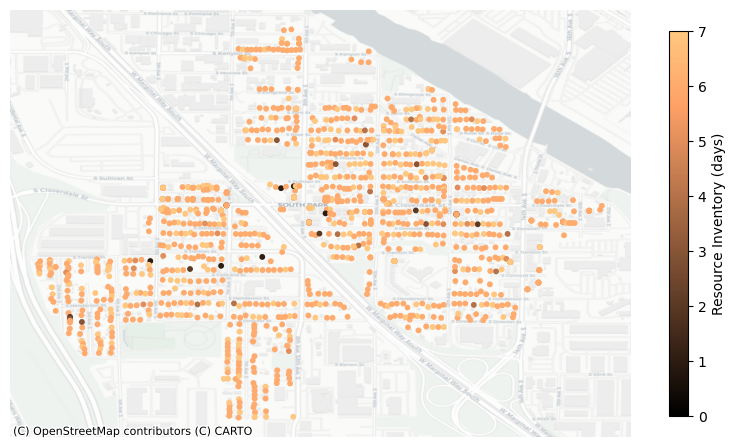

In [ ]:
# plot the final resource inventory
fig, ax = plt.subplots(figsize=(10, 10))

# set the node color to be proportional to the resource inventory
resource_inventory = model.resource
cmap = plt.cm.get_cmap('copper')  # Choose a colormap
node_color = resource_inventory / max(resource_inventory)
node_color_mapped = cmap(node_color)

# Plot the GeoDataFrame
gdf.plot(ax=ax, markersize=10, color=node_color_mapped, alpha=1)

# add base map
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=7))
sm.set_array(resource_inventory)
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label('Resource Inventory (days)')

plt.axis('off')
plt.show()

fig.savefig("../figs/southpark_transp_resource_redistribution.png", dpi=300, bbox_inches='tight')

# Step 5: Community-resilience analysis

ValueError: x and y must have same first dimension, but have shapes (601,) and (1, 601)

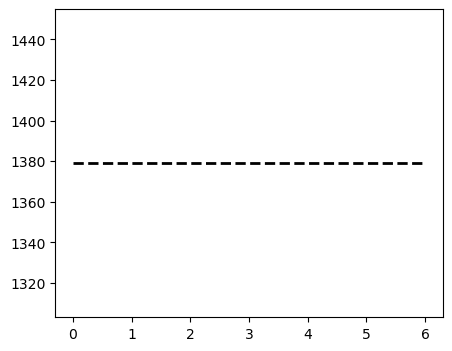

In [ ]:
time_stamps = np.arange(0, 6.01, 0.01)
num_households = len(community.nodes)
survival_curve_normal = num_households*np.ones_like(time_stamps)
survival_curve_with_sharing = src.get_survival_curve(model.resource, time_stamps=time_stamps)
survival_curve_without_sharing = src.get_survival_curve(model.inventory, time_stamps=time_stamps)

# print the survival curve of the all scenarios
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

plt.plot(time_stamps, survival_curve_normal, color='k', linestyle='dashed', linewidth=2, label='Normal state')
plt.plot(time_stamps, survival_curve_with_sharing, color='r', linestyle='-', linewidth=2, label='with P2P resoruce sharing')
plt.plot(time_stamps, survival_curve_without_sharing, color='b', linestyle='-', linewidth=2, label='Without P2P resource sharing')
plt.fill_between(time_stamps, survival_curve_with_sharing, survival_curve_normal, color='r', alpha=0.2)
# plt.fill_between(time_stamps[600:], survival_curve_with_sharing[600:], survival_curve_without_sharing[600:], color='r', alpha=0.2)
# plt.fill_between(time_stamps, survival_curve_without_sharing, color='b', alpha=0.2)
plt.fill_between(time_stamps, survival_curve_without_sharing, survival_curve_with_sharing, color='b', alpha=0.2)
plt.xlabel('Time (day)')
plt.ylabel('Average number of survival households')
plt.xlim(0, 6)
# plt.ylim(0, 1.05)
plt.legend()
plt.savefig('../figs/southpark_survival_curve.png', dpi=300, bbox_inches='tight')

In [ ]:
print("min survival rate with sharing:", min(survival_curve_with_sharing))
print("min survival rate without sharing:", min(survival_curve_without_sharing))

min survival rate with sharing: 1310.0
min survival rate without sharing: 1083.0


In [ ]:
# with sharing
print("RE:", src.get_resilience(x=time_stamps[0:601], y=survival_curve_with_sharing[0:601]))
print("RL:", src.get_resilience_loss(x=time_stamps[0:601], y=survival_curve_with_sharing[0:601]))

RE: 8099.345000000001
RL: 174.65499999999884


In [ ]:
# without sharing
print("RE:", src.get_resilience(x=time_stamps[0:601], y=survival_curve_without_sharing[0:601]))
print("RL:", src.get_resilience_loss(x=time_stamps[0:601], y=survival_curve_without_sharing[0:601]))

RE: 7435.48
RL: 838.5200000000004


In [ ]:
# resilience improvement
(src.get_resilience(x=time_stamps, y=survival_curve_with_sharing) - src.get_resilience(x=time_stamps, y=survival_curve_without_sharing))/src.get_resilience(x=time_stamps, y=survival_curve_without_sharing)

0.08928340873756659